In [ ]:
'''
    Device Failure Prediction 두 번째 내용입니다.
    이 프로젝트는 데이터 전처리와 Feature Engineering을 더해 가는 과정을 통해, 모델의 성능이 개선되는 
    것을 살펴보는 것이 목적입니다. 적용 대상 알고리즘은 Logistic Regression입니다.
    
    세 번째 Part에서는 
    - 아웃라이러 제거를 위해 아웃라이어 제거 기준이 되는 변수를 선택하여 아웃라이어를 제거한 뒤 모델 생성하고
    - 그타겟 변수에 가장 변별력이 떨어지는 변수를 drop한 후, 다시 모델을 생성하여 성능을 비교합니다.
    - 끝으로 Feature Importance 스코어를 변수별로 확인하고, drop한 변수의 Importance를 확인하여, Importance가 높다고 해서 
      모델의 성능에 절대적으로 긍정적인 영향을 끼치는 것은 아니라는 것을 확인합니다.
'''

In [2]:
# pandas 라이브러리를 import합니다.
import pandas as pd

In [4]:
# 구글 드라이브 마운트를 합니다.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
# 데이터 셑을 로딩합니다.
df = pd.read_csv("/content/drive/MyDrive/device.txt")

In [6]:
# 로딩이 제대로 됐는지 확인합니다.
df.head(5)

date    device  failure  ...  attribute7  attribute8  attribute9
0  2015-01-01  S1F01085        0  ...           0           0           7
1  2015-01-01  S1F0166B        0  ...           0           0           0
2  2015-01-01  S1F01E6Y        0  ...           0           0           0
3  2015-01-01  S1F01JE0        0  ...           0           0           0
4  2015-01-01  S1F01R2B        0  ...           0           0           3

[5 rows x 12 columns]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  object
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  int64 
 6   attribute4  124494 non-null  int64 
 7   attribute5  124494 non-null  int64 
 8   attribute6  124494 non-null  int64 
 9   attribute7  124494 non-null  int64 
 10  attribute8  124494 non-null  int64 
 11  attribute9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [8]:
# 널 값이 있는지 확인 합니다.
df.isnull().sum()

# 널 값은 없습니다.

date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64

In [9]:
# 결측치가 있는지 확인 합니다.
df.isna().sum()

# 결측치도 없습니다.

date          0
device        0
failure       0
attribute1    0
attribute2    0
attribute3    0
attribute4    0
attribute5    0
attribute6    0
attribute7    0
attribute8    0
attribute9    0
dtype: int64

In [10]:
# 각 컬럽별로 Unique한 값을 살펴 봅니다.
df.nunique()

date             304
device          1168
failure            2
attribute1    123878
attribute2       558
attribute3        47
attribute4       115
attribute5        60
attribute6     44838
attribute7        28
attribute8        28
attribute9        65
dtype: int64

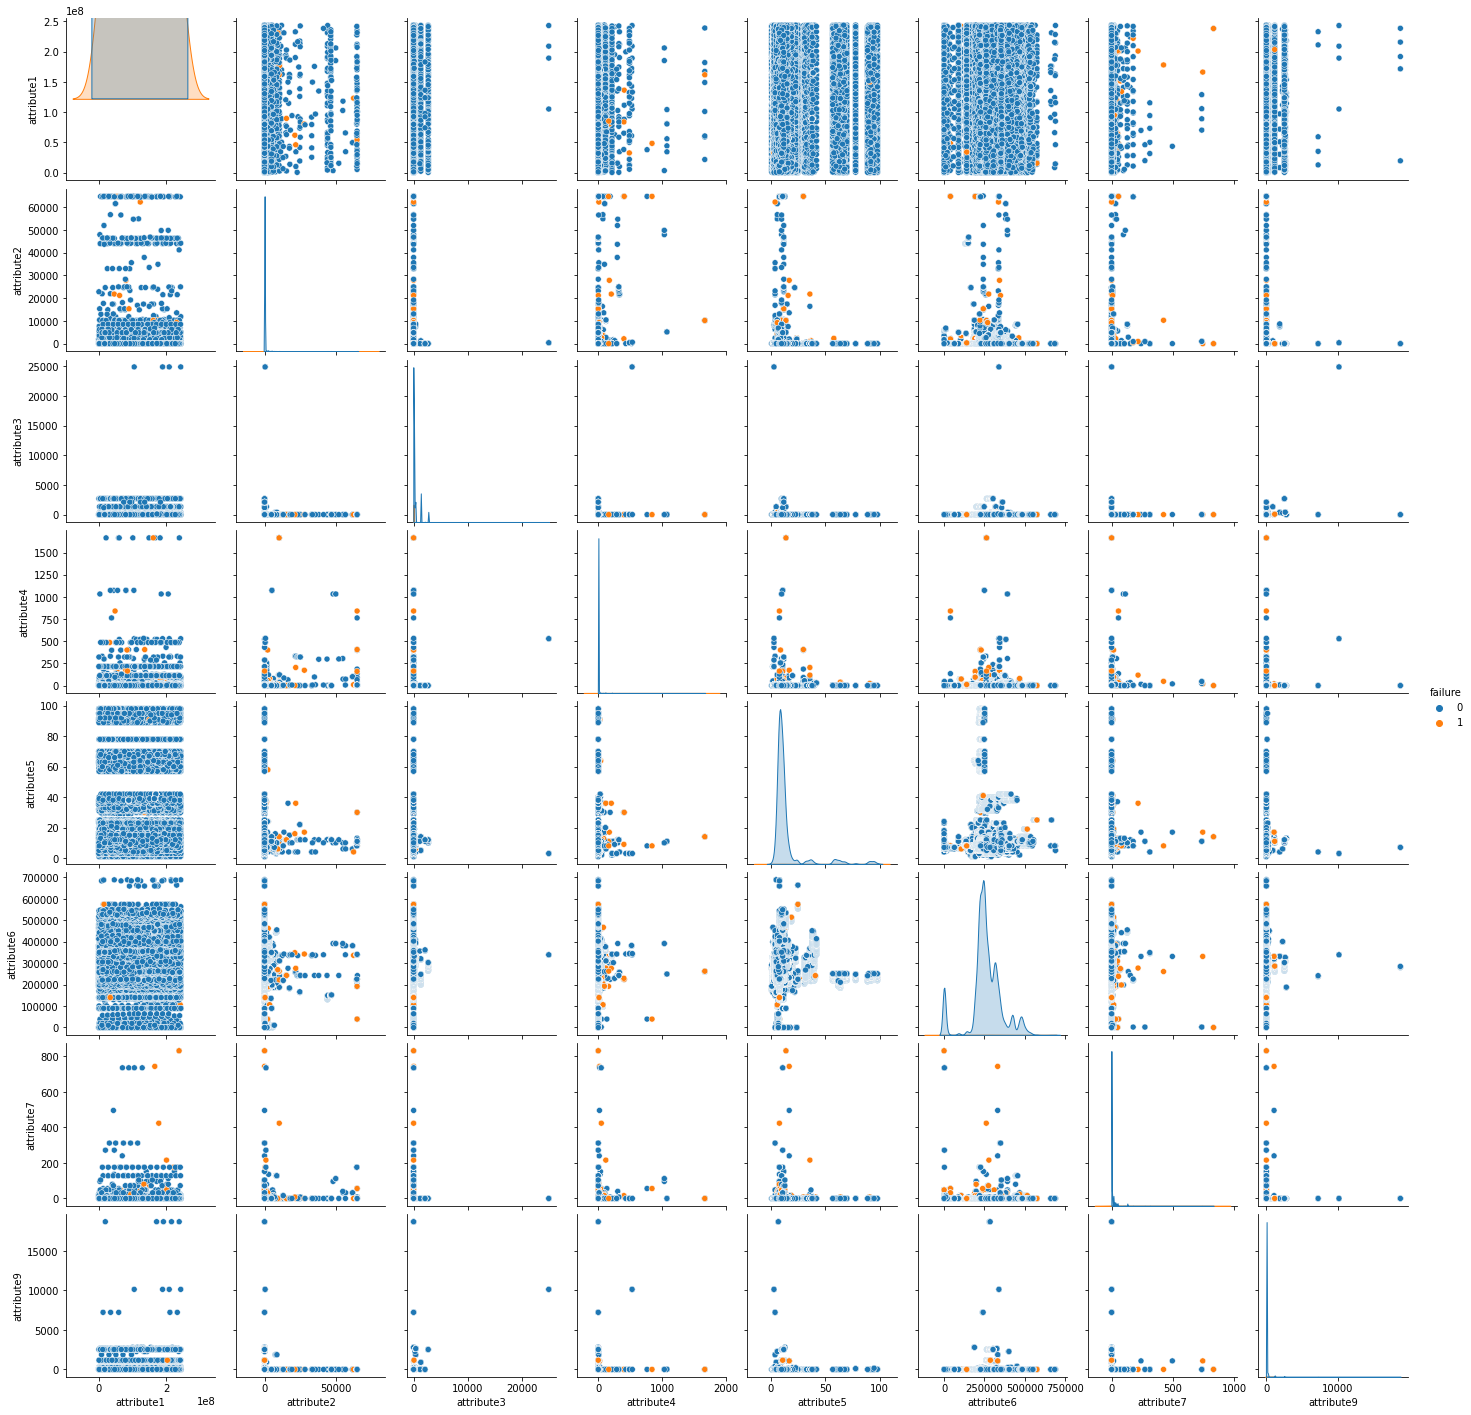

In [27]:
# 독립변수간의 상관관계를 Seaborn의 PairPlot을 이용하여 살펴봅니다.
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(df, hue='failure')

In [21]:
# 'attribute7' 과 'attribute8'이 완전한 선형 관계를 띄고 있습니다.
# 이 두 변수의 값이 모두 동일 한 것인지 확인하고 만약 동일 하다면 한 변수는 데이터 셑에서 drop 합니다.
import numpy as np

column_compare = pd.DataFrame(np.where(df['attribute7']==df['attribute8'], True, False))
column_compare.value_counts()

True    124494
dtype: int64

In [23]:
# 'attribute7'과 'attribute8'이 모두 동일한 값을 갖는 것으로 확인됩니다.
# 'attribute8'을 데이터 셑에서 drop합니다.

df.drop('attribute8', axis=1, inplace=True)

In [24]:
df.shape

(124494, 11)

In [ ]:
# 이번에는 Boxplot을 보고 아웃라이어를 제거할 변수를 선택합니다.

In [25]:
# Create Box Plots.
# Box Plot을 그릴 수가 정해져 있기 때문에 하드 코딩으로 진행 합니다.
def box_plots(df):
    f, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
    columns = [x for x in df.columns if x != 'failure' and x != 'date' and x != 'device']
    col = 0
    for r in range(2):
        for i in range(4):
            sns.boxplot(x=df.failure, y=columns[col], data=df, ax=axes[r][i])
            axes[r][i].set_title(columns[col] + ' vs Failure')
            col += 1

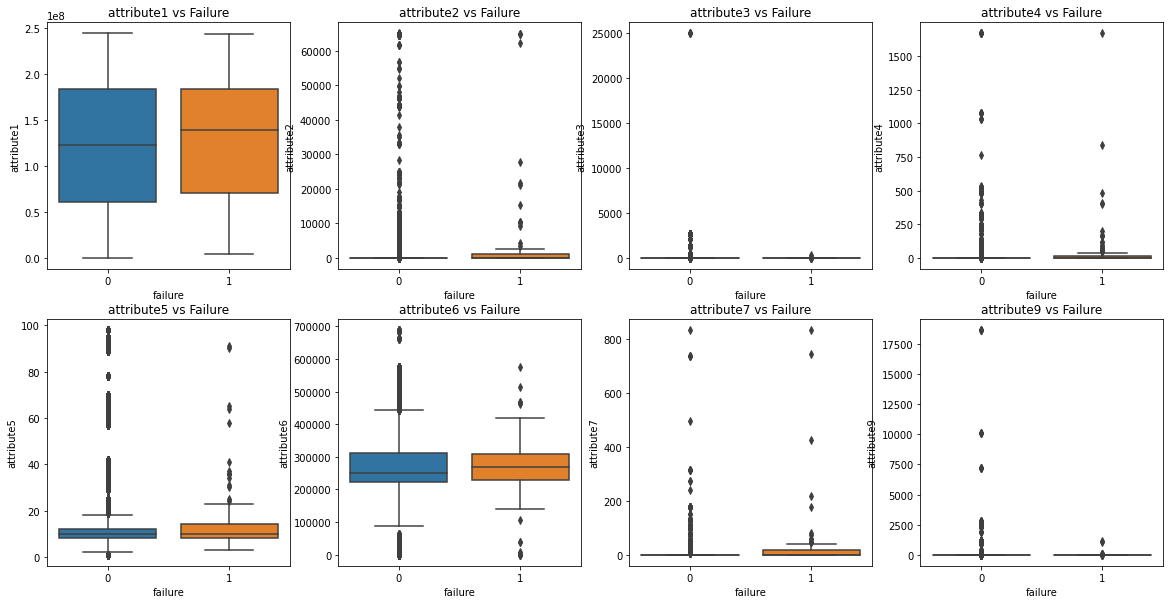

In [28]:
box_plots(df)

In [64]:
# 아웃라이어를 제거 함수 선언.
def remove_outlier_test(data_cp, column):
  #fraud_column_data = data_cp[data_cp['Class']==1][column] # 이 부분 수정.
  fraud_column_data = data_cp[data_cp['failure']==0][column] # 이 부분 수정.
  quan_25 = np.percentile(fraud_column_data.values, 25)
  quan_75 = np.percentile(fraud_column_data.values, 75)

  iqr = quan_75 - quan_25
  iqr = iqr * 1.5
  lowest = quan_25 - iqr
  highest = quan_75 + iqr
  outlier_index = fraud_column_data[(fraud_column_data < lowest) | (fraud_column_data > highest)].index
  print (len(outlier_index))
  data_cp.drop(outlier_index, axis = 0, inplace=True)
  print (data_cp.shape)
  return data_cp

In [45]:
# 모델 생성이 필요한 Scikit-Learn 라이브러리 import.
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [95]:
# 모델 생성 함수 정의
# 모델 생성 함수 
def logistic_regression_modeling(data_copy):
  # 트래인 데이터와 테스트 데이터 부분을 나눔.
  # 데이터 부분과 라벨 부분 분리.
  X = data_copy.iloc[:, 1:-1]
  Y = data_copy.iloc[:, 0]

  # 데이터 셑을 트래이닝 셑과 테스트 셑으로 나눕니다.
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=10)

  # 모델 생성. Convergence 문제가 발생할 수 있어, Max_Iter 파라미터를 설정해줘야 함.
  model = LogisticRegression(max_iter=1000) # 로지스틱 리그레션 모델.
  model.fit(X_train, Y_train)
  pred = model.predict(X_test)
  metrics(Y_test, pred)

In [38]:
# 모델 평가 함수 정의
def metrics(Y_test, pred):
  accuracy = accuracy_score(Y_test, pred)
  precision = precision_score(Y_test, pred)
  recall = recall_score(Y_test, pred)
  f1 = f1_score(Y_test, pred)
  roc_score = roc_auc_score(Y_test, pred, average='macro')
  print ('정확도: {0:.2f}, 정밀도: {1:.2f}, 재현율: {2: .2f}'.format(accuracy, precision, recall))
  print ('f1-score: {0:.2f}, auc: {1:.2f}'.format(f1, roc_score))

6336
(118158, 9)
정확도: 1.00, 정밀도: 0.89, 재현율:  0.48
f1-score: 0.63, auc: 0.74


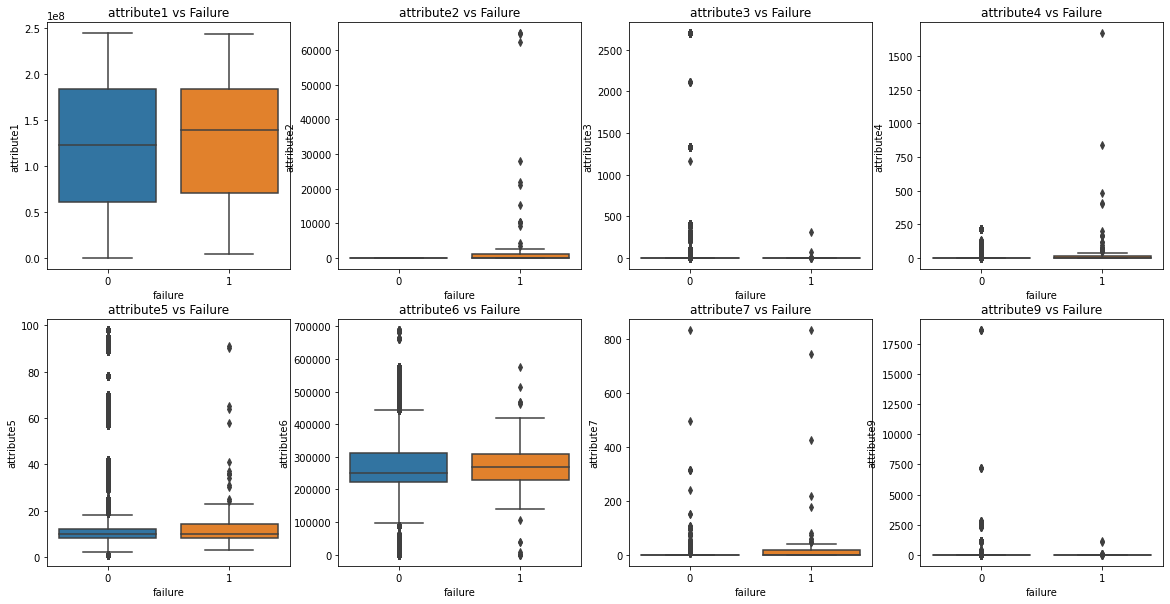

In [153]:
# 트래인 데이터와 테스트 데이터 부분으로 데이터 셑을 나누기 위해, 데이터 셑의 카피본을 만듭니다.
# 그리고 'date'와 'device'변수는 수치형이 현재 아니기 때문에 drop 합니다.
df_copy = df.copy()
df_copy = df_copy.drop(['date', 'device'], axis=1)
  
# 'attribute2'의 0을 기준으로 아웃라이어에 해당하는 레코드를 모두 제거합니다.
df_copy = remove_outlier_test(df_copy, 'attribute2')

# Box Plot를 출력합니다. Box Plot은 한 번만 출력해 봅니다.
box_plots(df_copy)

# 모델을 생성합니다.
logistic_regression_modeling(df_copy)

In [154]:
# 트래인 데이터와 테스트 데이터 부분으로 데이터 셑을 나누기 위해, 데이터 셑의 카피본을 만듭니다.
# 그리고 'date'와 'device'변수는 수치형이 현재 아니기 때문에 drop 합니다.
df_copy = df.copy()
df_copy = df_copy.drop(['date', 'device'], axis=1)
  
# 'attribute2'의 0을 기준으로 아웃라이어에 해당하는 레코드를 모두 제거합니다.
df_copy = remove_outlier_test(df_copy, 'attribute3')

# 모델을 생성합니다.
logistic_regression_modeling(df_copy)

9124
(115370, 9)
정확도: 1.00, 정밀도: 0.00, 재현율:  0.00
f1-score: 0.00, auc: 0.50


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [156]:
# 트래인 데이터와 테스트 데이터 부분으로 데이터 셑을 나누기 위해, 데이터 셑의 카피본을 만듭니다.
# 그리고 'date'와 'device'변수는 수치형이 현재 아니기 때문에 drop 합니다.
df_copy = df.copy()
df_copy = df_copy.drop(['date', 'device'], axis=1)
  
# 'attribute2'의 0을 기준으로 아웃라이어에 해당하는 레코드를 모두 제거합니다.
df_copy = remove_outlier_test(df_copy, 'attribute4')

# 모델을 생성합니다.
logistic_regression_modeling(df_copy)

9276
(115218, 9)
정확도: 1.00, 정밀도: 0.00, 재현율:  0.00
f1-score: 0.00, auc: 0.50


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [157]:
# 트래인 데이터와 테스트 데이터 부분으로 데이터 셑을 나누기 위해, 데이터 셑의 카피본을 만듭니다.
# 그리고 'date'와 'device'변수는 수치형이 현재 아니기 때문에 drop 합니다.
df_copy = df.copy()
df_copy = df_copy.drop(['date', 'device'], axis=1)
  
# 'attribute2'의 0을 기준으로 아웃라이어에 해당하는 레코드를 모두 제거합니다.
df_copy = remove_outlier_test(df_copy, 'attribute5')

# 모델을 생성합니다.
logistic_regression_modeling(df_copy)

14123
(110371, 9)
정확도: 1.00, 정밀도: 0.00, 재현율:  0.00
f1-score: 0.00, auc: 0.50


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [158]:
# 트래인 데이터와 테스트 데이터 부분으로 데이터 셑을 나누기 위해, 데이터 셑의 카피본을 만듭니다.
# 그리고 'date'와 'device'변수는 수치형이 현재 아니기 때문에 drop 합니다.
df_copy = df.copy()
df_copy = df_copy.drop(['date', 'device'], axis=1)
  
# 'attribute2'의 0을 기준으로 아웃라이어에 해당하는 레코드를 모두 제거합니다.
df_copy = remove_outlier_test(df_copy, 'attribute6')

# 모델을 생성합니다.
logistic_regression_modeling(df_copy)

14378
(110116, 9)
정확도: 1.00, 정밀도: 0.00, 재현율:  0.00
f1-score: 0.00, auc: 0.50


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [159]:
# 트래인 데이터와 테스트 데이터 부분으로 데이터 셑을 나누기 위해, 데이터 셑의 카피본을 만듭니다.
# 그리고 'date'와 'device'변수는 수치형이 현재 아니기 때문에 drop 합니다.
df_copy = df.copy()
df_copy = df_copy.drop(['date', 'device'], axis=1)
  
# 'attribute2'의 0을 기준으로 아웃라이어에 해당하는 레코드를 모두 제거합니다.
df_copy = remove_outlier_test(df_copy, 'attribute7')

# 모델을 생성합니다.
logistic_regression_modeling(df_copy)

1419
(123075, 9)
정확도: 1.00, 정밀도: 0.00, 재현율:  0.00
f1-score: 0.00, auc: 0.50


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [160]:
# 트래인 데이터와 테스트 데이터 부분으로 데이터 셑을 나누기 위해, 데이터 셑의 카피본을 만듭니다.
# 그리고 'date'와 'device'변수는 수치형이 현재 아니기 때문에 drop 합니다.
df_copy = df.copy()
df_copy = df_copy.drop(['date', 'device'], axis=1)
  
# 'attribute2'의 0을 기준으로 아웃라이어에 해당하는 레코드를 모두 제거합니다.
df_copy = remove_outlier_test(df_copy, 'attribute9')

# 모델을 생성합니다.
logistic_regression_modeling(df_copy)

27106
(97388, 9)
정확도: 1.00, 정밀도: 0.00, 재현율:  0.00
f1-score: 0.00, auc: 0.50


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [161]:
# 트래인 데이터와 테스트 데이터 부분으로 데이터 셑을 나누기 위해, 데이터 셑의 카피본을 만듭니다.
# 그리고 'date'와 'device'변수는 수치형이 현재 아니기 때문에 drop 합니다.
df_copy = df.copy()
  
# 'attribute2'의 0을 기준으로 아웃라이어에 해당하는 레코드를 모두 제거합니다.
df_copy = remove_outlier_test(df_copy, 'attribute2')
df_copy = df_copy.drop(['date', 'device', 'attribute1'], axis=1)

# 모델을 생성합니다.
logistic_regression_modeling(df_copy)

6336
(118158, 11)
정확도: 1.00, 정밀도: 1.00, 재현율:  0.52
f1-score: 0.68, auc: 0.76


In [ ]:
# 이 번 Part 3에서 아웃라이어를 제거 한 후 모델을 생성하여 성능을 봤을 때, 특정 변수를 임으로 선택하여 아웃라이어만을 제거했는데도
# 모델의 성능이 개선되는 것을 확인 했습니다. 그리고, 아웃라이어를 제거한 후, 타겟 변수의 변별력이 가장 떨어지는 변수를 drop하니
# 모델의 성능이 다시 개선되는 것도 확인 했습니다. 
# - 아웃 라이어를 제거할 때, 어떤 변수를 택하여 아웃라이어를 제거할 것 인지와[아웃라이어를 제거하기 위해 박스 플랏의 IQR범위에서 변수의 값들이 많이 벋어나는 변수를 선택한다.]
# - 아웃 라이어를 제거한 후, 타겟 변수의 변별력이 가장 떨어 지는 변수[0의 값을 더 많이 갖는 변수: 박스 플랏에서 1의 값의 범위 보다 0의 값을 갖는 범위가 넓은 변수]를 
# 선택하는 것이 모델 성능에 영향을 준다는 것을 확인할 수 있었습니다.

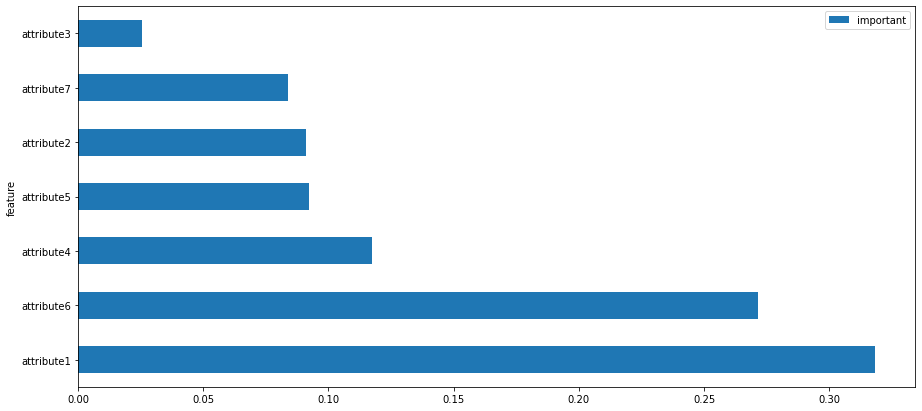

In [163]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=50, max_features='auto')
clf= clf.fit(X,Y)

features = pd.DataFrame()
features['feature']= X.columns
features['important']=clf.feature_importances_
features.sort_values(by=['important'], ascending=False,inplace=True)
features.set_index('feature', inplace=True)
features.iloc[:,:].plot(kind='barh', figsize=(15,7))

In [ ]:
# 위의 Feature Importance을 보면 attribute1이 높은 수치의 importance를 가지지만, 타겟 변수의 값 중에 0과 1중에 어떤 값에 관계를 많이 
# 갖는 지도 영향이 있다는 것을 알 수 있습니다.